In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
area_pre_feature_selection = pd.read_csv('../../data/pre_training/area_pre_feature_selection.csv')
district_pre_feature_selection = pd.read_csv('../../data/pre_training/district_pre_feature_selection.csv')

In [3]:
area_features = area_pre_feature_selection.drop('area_crimes_this_hour', axis=1)
district_features = district_pre_feature_selection.drop('district_crimes_this_hour', axis=1)

area_target = area_pre_feature_selection[['year', 'area_crimes_this_hour']]
district_target = district_pre_feature_selection[['year', 'district_crimes_this_hour']]

In [4]:
# break the area dataset into testing and training datasets
area_feature_training_data = area_features[area_features['year'] < 2020].reset_index(drop=True)
area_feature_testing_data = area_features[area_features['year'] == 2020].reset_index(drop=True)

area_target_training_data = area_target[area_target['year'] < 2020].reset_index(drop=True)
area_target_testing_data = area_target[area_target['year'] == 2020].reset_index(drop=True)

In [5]:
# break the district dataset into testing and training datasets
district_feature_training_data = district_features[district_features['year'] < 2020].reset_index(drop=True)
district_feature_testing_data = district_features[district_features['year'] == 2020].reset_index(drop=True)

district_target_training_data = district_target[district_target['year'] < 2020].reset_index(drop=True)
district_target_testing_data = district_target[district_target['year'] == 2020].reset_index(drop=True)

In [6]:
area_target_training_data = area_target_training_data.drop('year', axis=1)
area_target_testing_data = area_target_testing_data.drop('year', axis=1)
district_target_training_data = district_target_training_data.drop('year', axis=1)
district_target_testing_data = district_target_testing_data.drop('year', axis=1)

## Linear Regression

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

##### Final Feature Engineering

In [8]:
lr_area_feature_training_data = area_feature_training_data.drop('date_hour', axis=1)
lr_area_feature_testing_data = area_feature_testing_data.drop('date_hour', axis=1)

lr_district_feature_training_data = district_feature_training_data.drop('date_hour', axis=1)
lr_district_feature_testing_data = district_feature_testing_data.drop('date_hour', axis=1)

In [9]:
# target encoding of district/area columns
area_means = area_pre_feature_selection.groupby('area_id')['area_crimes_this_hour'].mean()
district_means = district_pre_feature_selection.groupby('district')['district_crimes_this_hour'].mean()

lr_area_feature_training_data['area_id_target_encoded'] = lr_area_feature_training_data['area_id'].map(area_means)
lr_area_feature_testing_data['area_id_target_encoded'] = lr_area_feature_testing_data['area_id'].map(area_means)

lr_district_feature_training_data['district_target_encoded'] = lr_district_feature_training_data['district'].map(district_means)
lr_district_feature_testing_data['district_target_encoded'] = lr_district_feature_testing_data['district'].map(district_means)

In [10]:
# frequency encoding of district/area columns
area_freq = area_pre_feature_selection['area_id'].value_counts() / len(area_pre_feature_selection)
district_freq = district_pre_feature_selection['district'].value_counts() / len(district_pre_feature_selection)

lr_area_feature_training_data['area_id_freq_encoded'] = lr_area_feature_training_data['area_id'].map(area_freq)
lr_area_feature_testing_data['area_id_freq_encoded'] = lr_area_feature_testing_data['area_id'].map(area_freq)

lr_district_feature_training_data['district_freq_encoded'] = lr_district_feature_training_data['district'].map(district_freq)
lr_district_feature_testing_data['district_freq_encoded'] = lr_district_feature_testing_data['district'].map(district_freq)

In [11]:
lr_area_feature_training_data.drop('area_id', axis=1, inplace=True)
lr_area_feature_testing_data.drop('area_id', axis=1, inplace=True)

lr_district_feature_training_data.drop('district', axis=1, inplace=True)
lr_district_feature_testing_data.drop('district', axis=1, inplace=True)

In [12]:
def patch_datatypes(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype(np.float32)

    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype(np.int32)    
      
    return df

In [13]:
lr_area_feature_training_data = patch_datatypes(lr_area_feature_training_data)

In [14]:
lr_area_feature_testing_data = patch_datatypes(lr_area_feature_testing_data)

In [15]:
lr_district_feature_training_data = patch_datatypes(lr_district_feature_training_data)

In [16]:
lr_district_feature_testing_data = patch_datatypes(lr_district_feature_testing_data)

In [17]:
def generate_correlation_heatmap(df):
    # Generate a mask to onlyshow the bottom triangle
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))

    # generate heatmap
    plt.figure(figsize=(70,70))
    sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
    plt.title('Correlation Coefficient Of Area Crime Predictors')
    plt.show()

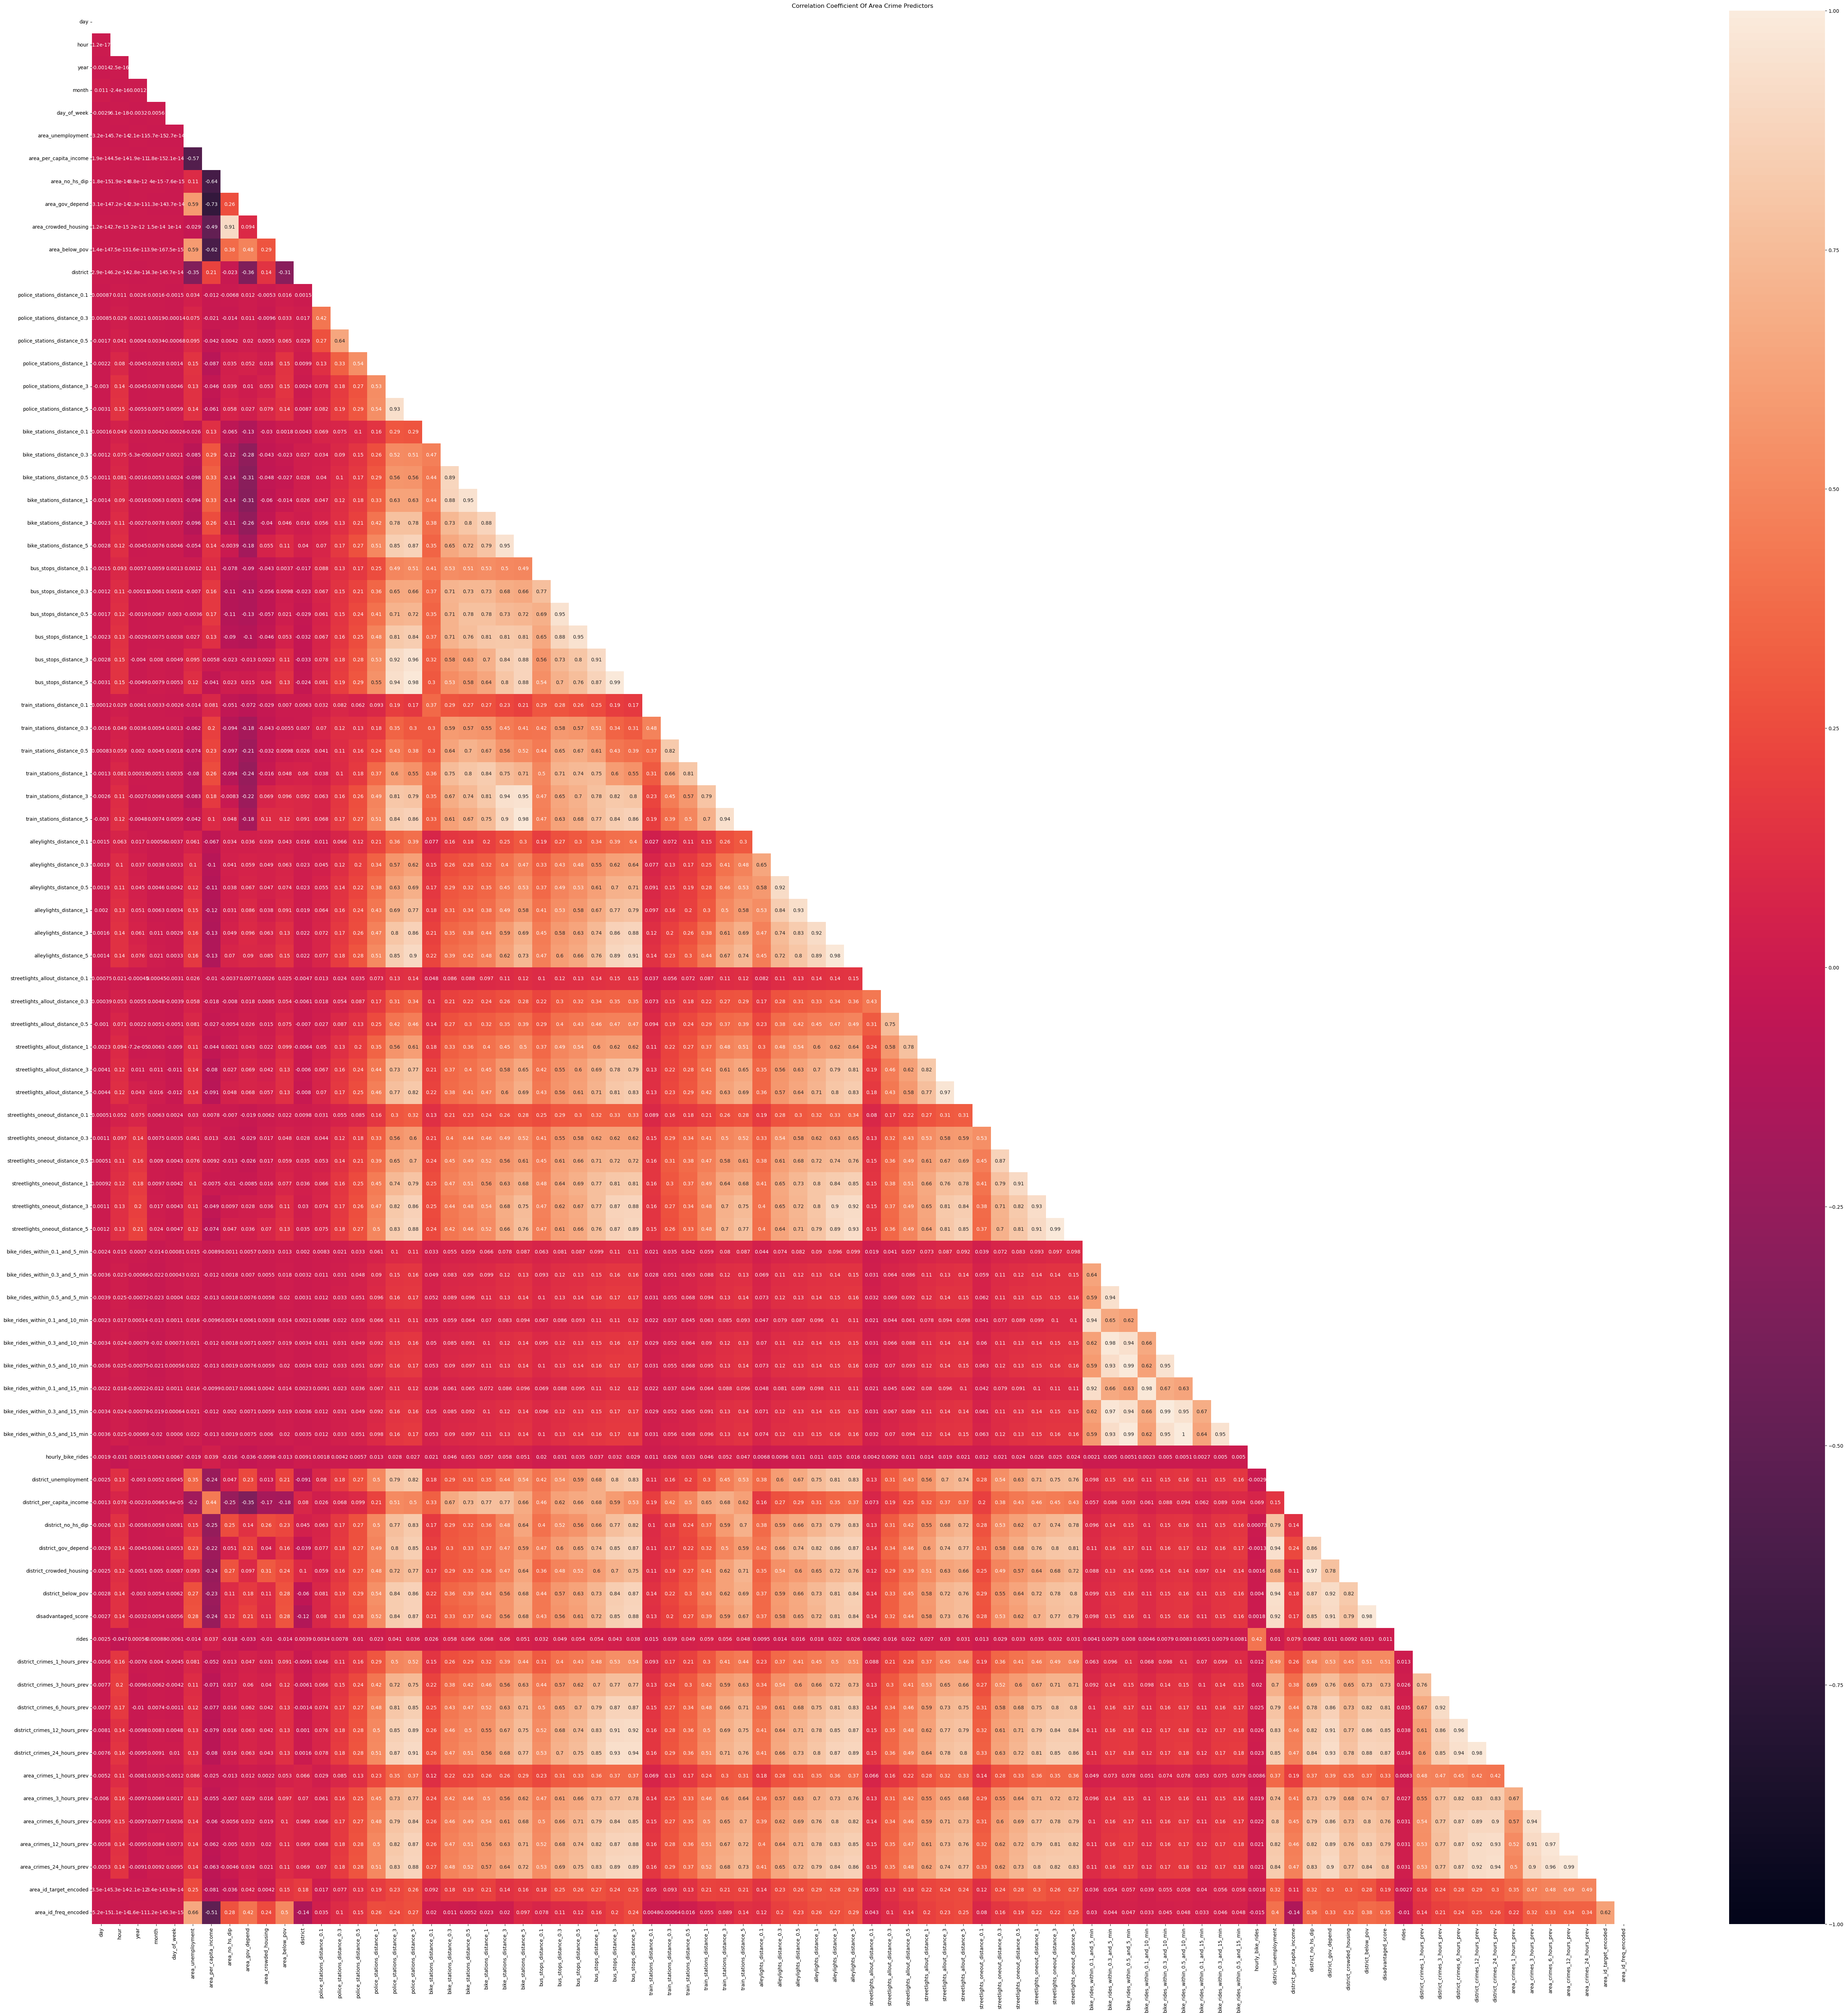

In [18]:
generate_correlation_heatmap(lr_area_feature_training_data)

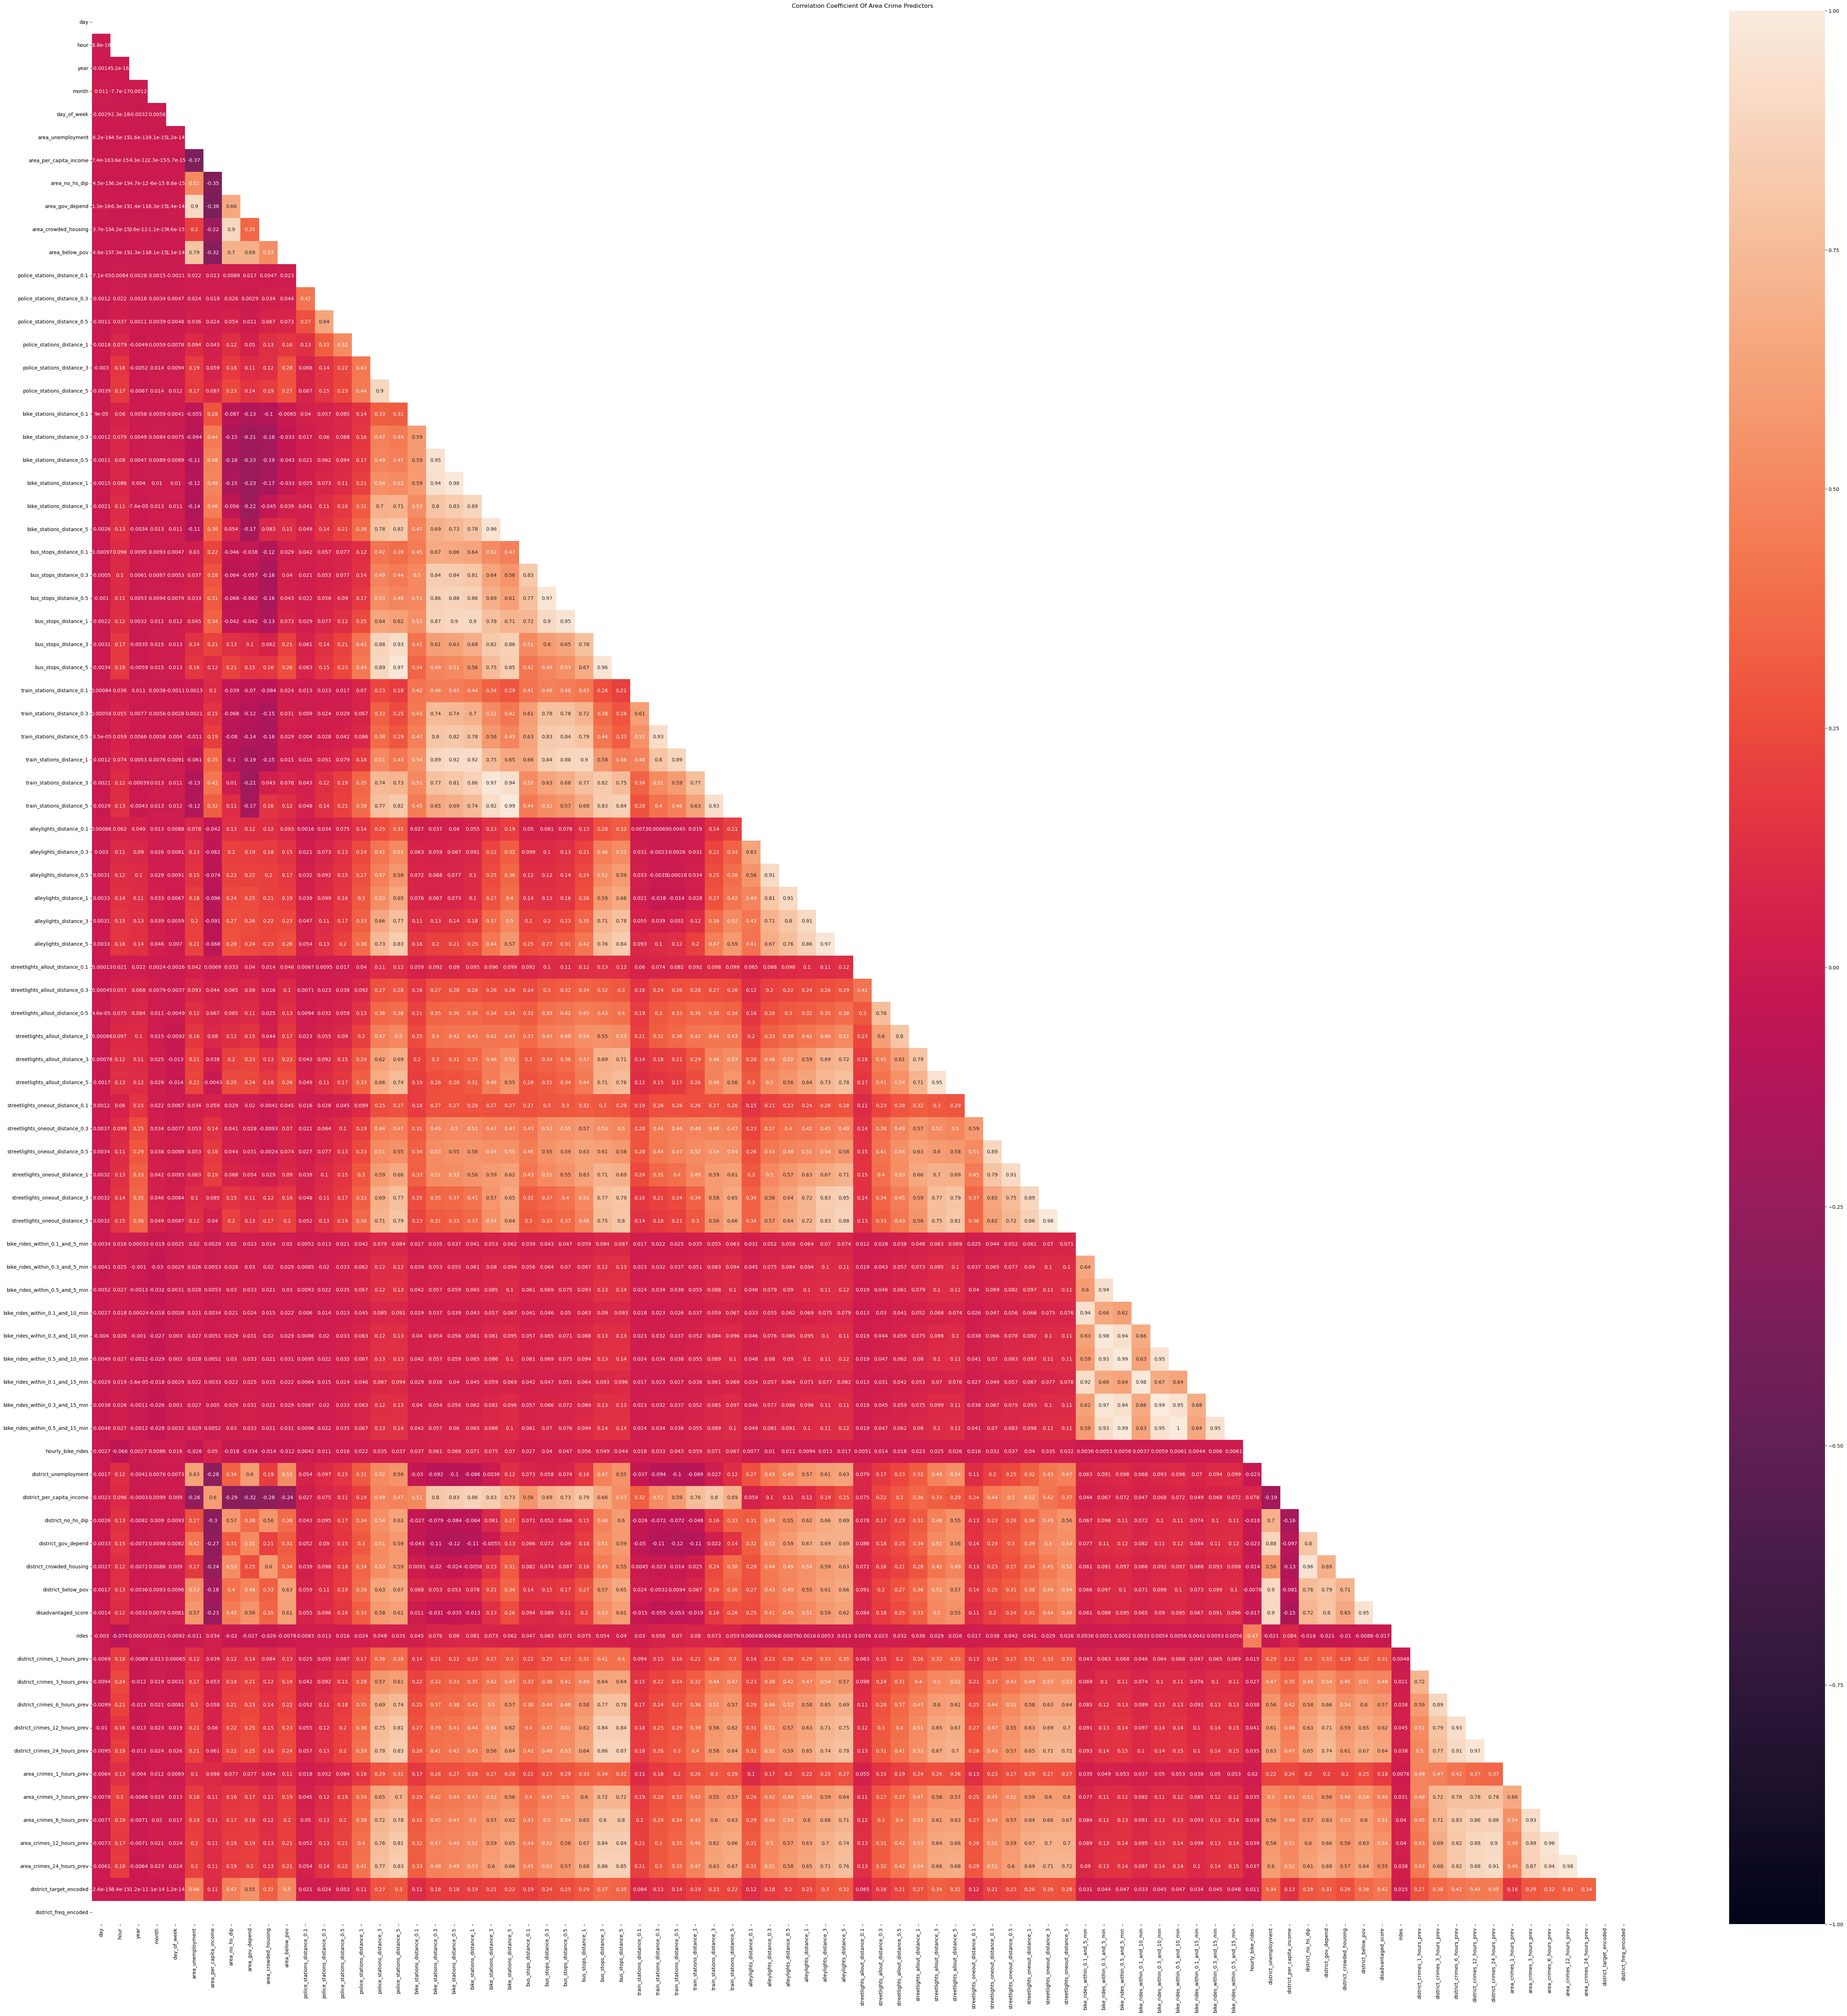

In [19]:
generate_correlation_heatmap(lr_district_feature_training_data)

##### Using VIF to Remove Multicollinearity

In [18]:
# Function to compute VIF for all features
def compute_vif(feature_df):
    print(f"{datetime.now()} - Starting VIF computation")
    X = feature_df.copy()
    # The calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # Create dataframe to store VIF values
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['feature'] != 'intercept']
    
    print(f"{datetime.now()} - Completed VIF computation")
    return vif

In [19]:
# Function to optimize VIF by dropping features with high VIF values
def optimize_vif(feature_df, vif_threshold):
    print(f"{datetime.now()} - Starting VIF optimization")
    df = feature_df.copy()       

    vif_df = compute_vif(feature_df)
    
    while (vif_df['vif'] >= vif_threshold).any():
        print(f"{datetime.now()} - Current VIF values:\n{vif_df}")
        largest_vif_feature = vif_df.loc[vif_df['vif'].idxmax(), 'feature']
        print(f"{datetime.now()} - Dropping feature: {largest_vif_feature} with VIF score of: {vif_df['vif'].max()}")
        df = df.drop(columns=[largest_vif_feature])
        vif_df = compute_vif(df)
    
    print(f"{datetime.now()} - Completed VIF optimization")
    return vif_df

In [22]:
lr_area_selected_features_ten = optimize_vif(lr_area_feature_training_data, 10)

2024-07-19 15:28:59.196830 - Starting VIF optimization
2024-07-19 15:29:01.041855 - Starting VIF computation
2024-07-19 18:14:39.461333 - Completed VIF computation
2024-07-19 18:14:39.564272 - Current VIF values:
                      feature        vif
0                         day   1.000973
1                        hour   1.071720
2                        year   1.385042
3                       month   1.009107
4                 day_of_week   1.003863
..                        ...        ...
79   area_crimes_6_hours_prev  30.939784
80  area_crimes_12_hours_prev  60.148103
81  area_crimes_24_hours_prev  64.374966
82     area_id_target_encoded   3.668559
83       area_id_freq_encoded   4.163961

[84 rows x 2 columns]
2024-07-19 18:14:39.692281 - Dropping feature: bike_rides_within_0.5_and_10_min with VIF score of: 397.2050673585524
2024-07-19 18:14:44.176707 - Starting VIF computation
2024-07-19 20:54:22.032445 - Completed VIF computation
2024-07-19 20:54:22.144327 - Current VIF value

In [23]:
lr_district_selected_features_ten = optimize_vif(lr_district_feature_training_data, 10)

2024-07-21 16:31:36.585827 - Starting VIF optimization
2024-07-21 16:31:37.578888 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 16:40:20.434781 - Completed VIF computation
2024-07-21 16:40:20.440287 - Current VIF values:
                      feature        vif
0                         day   1.001084
1                        hour   1.117385
2                        year   1.780925
3                       month   1.015479
4                 day_of_week   1.007877
..                        ...        ...
78   area_crimes_6_hours_prev  23.457347
79  area_crimes_12_hours_prev  43.585544
80  area_crimes_24_hours_prev  42.871171
81    district_target_encoded   3.362114
82      district_freq_encoded   0.000000

[83 rows x 2 columns]
2024-07-21 16:40:20.443226 - Dropping feature: bike_rides_within_0.5_and_10_min with VIF score of: 386.2277115562501
2024-07-21 16:40:20.484817 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 16:48:44.911141 - Completed VIF computation
2024-07-21 16:48:44.916656 - Current VIF values:
                      feature        vif
0                         day   1.001084
1                        hour   1.117385
2                        year   1.780925
3                       month   1.015473
4                 day_of_week   1.007874
..                        ...        ...
77   area_crimes_6_hours_prev  23.457196
78  area_crimes_12_hours_prev  43.584667
79  area_crimes_24_hours_prev  42.870313
80    district_target_encoded   3.362112
81      district_freq_encoded   0.000000

[82 rows x 2 columns]
2024-07-21 16:48:44.917657 - Dropping feature: bike_stations_distance_5 with VIF score of: 196.49226100425435
2024-07-21 16:48:44.960083 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 16:56:54.494128 - Completed VIF computation
2024-07-21 16:56:54.499133 - Current VIF values:
                      feature        vif
0                         day   1.001081
1                        hour   1.117384
2                        year   1.780700
3                       month   1.015464
4                 day_of_week   1.007868
..                        ...        ...
76   area_crimes_6_hours_prev  23.457191
77  area_crimes_12_hours_prev  43.580324
78  area_crimes_24_hours_prev  42.549827
79    district_target_encoded   3.360964
80      district_freq_encoded   0.000000

[81 rows x 2 columns]
2024-07-21 16:56:54.500134 - Dropping feature: bus_stops_distance_5 with VIF score of: 153.0571583722154
2024-07-21 16:56:54.542115 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:04:49.875644 - Completed VIF computation
2024-07-21 17:04:49.881184 - Current VIF values:
                      feature        vif
0                         day   1.001072
1                        hour   1.117383
2                        year   1.768369
3                       month   1.014720
4                 day_of_week   1.007852
..                        ...        ...
75   area_crimes_6_hours_prev  23.457139
76  area_crimes_12_hours_prev  43.580323
77  area_crimes_24_hours_prev  42.520030
78    district_target_encoded   3.359583
79      district_freq_encoded   0.000000

[80 rows x 2 columns]
2024-07-21 17:04:49.882185 - Dropping feature: bike_rides_within_0.3_and_10_min with VIF score of: 126.70641307277383
2024-07-21 17:04:49.923254 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:12:27.343228 - Completed VIF computation
2024-07-21 17:12:27.348274 - Current VIF values:
                      feature        vif
0                         day   1.001069
1                        hour   1.117382
2                        year   1.768369
3                       month   1.014712
4                 day_of_week   1.007852
..                        ...        ...
74   area_crimes_6_hours_prev  23.457115
75  area_crimes_12_hours_prev  43.580321
76  area_crimes_24_hours_prev  42.520025
77    district_target_encoded   3.359580
78      district_freq_encoded   0.000000

[79 rows x 2 columns]
2024-07-21 17:12:27.349275 - Dropping feature: streetlights_oneout_distance_5 with VIF score of: 81.12921970634254
2024-07-21 17:12:27.389761 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:19:48.418166 - Completed VIF computation
2024-07-21 17:19:48.423675 - Current VIF values:
                      feature        vif
0                         day   1.001031
1                        hour   1.117381
2                        year   1.643240
3                       month   1.013854
4                 day_of_week   1.007761
..                        ...        ...
73   area_crimes_6_hours_prev  23.457000
74  area_crimes_12_hours_prev  43.580306
75  area_crimes_24_hours_prev  42.519503
76    district_target_encoded   3.359577
77      district_freq_encoded   0.000000

[78 rows x 2 columns]
2024-07-21 17:19:48.424676 - Dropping feature: bike_rides_within_0.5_and_15_min with VIF score of: 81.03233882883096
2024-07-21 17:19:48.464254 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:26:55.794227 - Completed VIF computation
2024-07-21 17:26:55.799741 - Current VIF values:
                      feature        vif
0                         day   1.001031
1                        hour   1.117380
2                        year   1.643233
3                       month   1.013664
4                 day_of_week   1.007761
..                        ...        ...
72   area_crimes_6_hours_prev  23.456970
73  area_crimes_12_hours_prev  43.580268
74  area_crimes_24_hours_prev  42.519503
75    district_target_encoded   3.359534
76      district_freq_encoded   0.000000

[77 rows x 2 columns]
2024-07-21 17:26:55.800743 - Dropping feature: bike_stations_distance_3 with VIF score of: 74.27409094889715
2024-07-21 17:26:55.841322 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:33:46.738482 - Completed VIF computation
2024-07-21 17:33:46.742994 - Current VIF values:
                      feature        vif
0                         day   1.001031
1                        hour   1.117379
2                        year   1.641584
3                       month   1.013314
4                 day_of_week   1.007754
..                        ...        ...
71   area_crimes_6_hours_prev  23.456967
72  area_crimes_12_hours_prev  43.578177
73  area_crimes_24_hours_prev  42.449718
74    district_target_encoded   3.304823
75      district_freq_encoded   0.000000

[76 rows x 2 columns]
2024-07-21 17:33:46.744381 - Dropping feature: district_no_hs_dip with VIF score of: 72.07655416521729
2024-07-21 17:33:46.782439 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:40:24.535673 - Completed VIF computation
2024-07-21 17:40:24.541182 - Current VIF values:
                      feature        vif
0                         day   1.001027
1                        hour   1.117379
2                        year   1.641234
3                       month   1.013311
4                 day_of_week   1.007737
..                        ...        ...
70   area_crimes_6_hours_prev  23.456961
71  area_crimes_12_hours_prev  43.578168
72  area_crimes_24_hours_prev  42.433134
73    district_target_encoded   2.987656
74      district_freq_encoded   0.000000

[75 rows x 2 columns]
2024-07-21 17:40:24.542183 - Dropping feature: district_below_pov with VIF score of: 55.81954148044386
2024-07-21 17:40:24.579517 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:46:47.811161 - Completed VIF computation
2024-07-21 17:46:47.816671 - Current VIF values:
                      feature        vif
0                         day   1.001025
1                        hour   1.117368
2                        year   1.641073
3                       month   1.013269
4                 day_of_week   1.007736
..                        ...        ...
69   area_crimes_6_hours_prev  23.456944
70  area_crimes_12_hours_prev  43.577599
71  area_crimes_24_hours_prev  42.394822
72    district_target_encoded   2.836373
73      district_freq_encoded   0.000000

[74 rows x 2 columns]
2024-07-21 17:46:47.817671 - Dropping feature: bike_stations_distance_1 with VIF score of: 51.490419570892236
2024-07-21 17:46:47.854599 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:52:58.111921 - Completed VIF computation
2024-07-21 17:52:58.120960 - Current VIF values:
                      feature        vif
0                         day   1.001024
1                        hour   1.117367
2                        year   1.640167
3                       month   1.013056
4                 day_of_week   1.007735
..                        ...        ...
68   area_crimes_6_hours_prev  23.456797
69  area_crimes_12_hours_prev  43.576286
70  area_crimes_24_hours_prev  42.393470
71    district_target_encoded   2.835132
72      district_freq_encoded   0.000000

[73 rows x 2 columns]
2024-07-21 17:52:58.124019 - Dropping feature: bus_stops_distance_0.5 with VIF score of: 47.03392028265936
2024-07-21 17:52:58.206816 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 17:58:53.257959 - Completed VIF computation
2024-07-21 17:58:53.262467 - Current VIF values:
                      feature        vif
0                         day   1.001023
1                        hour   1.117317
2                        year   1.640129
3                       month   1.013042
4                 day_of_week   1.007735
..                        ...        ...
67   area_crimes_6_hours_prev  23.456368
68  area_crimes_12_hours_prev  43.575111
69  area_crimes_24_hours_prev  42.393410
70    district_target_encoded   2.835019
71      district_freq_encoded   0.000000

[72 rows x 2 columns]
2024-07-21 17:58:53.263468 - Dropping feature: area_crimes_12_hours_prev with VIF score of: 43.5751110046902
2024-07-21 17:58:53.300037 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:04:36.316816 - Completed VIF computation
2024-07-21 18:04:36.321822 - Current VIF values:
                      feature        vif
0                         day   1.001015
1                        hour   1.116644
2                        year   1.640126
3                       month   1.013014
4                 day_of_week   1.007693
..                        ...        ...
66   area_crimes_3_hours_prev  10.702951
67   area_crimes_6_hours_prev  18.924342
68  area_crimes_24_hours_prev  22.892934
69    district_target_encoded   2.833555
70      district_freq_encoded   0.000000

[71 rows x 2 columns]
2024-07-21 18:04:36.323824 - Dropping feature: alleylights_distance_3 with VIF score of: 42.42123663365886
2024-07-21 18:04:36.359648 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:10:05.884573 - Completed VIF computation
2024-07-21 18:10:05.889577 - Current VIF values:
                      feature        vif
0                         day   1.000998
1                        hour   1.116628
2                        year   1.616431
3                       month   1.011202
4                 day_of_week   1.007600
..                        ...        ...
65   area_crimes_3_hours_prev  10.702897
66   area_crimes_6_hours_prev  18.923906
67  area_crimes_24_hours_prev  22.890670
68    district_target_encoded   2.831116
69      district_freq_encoded   0.000000

[70 rows x 2 columns]
2024-07-21 18:10:05.890578 - Dropping feature: bus_stops_distance_3 with VIF score of: 41.10442964368803
2024-07-21 18:10:05.926351 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:15:22.724327 - Completed VIF computation
2024-07-21 18:15:22.729331 - Current VIF values:
                      feature        vif
0                         day   1.000996
1                        hour   1.116617
2                        year   1.606942
3                       month   1.010982
4                 day_of_week   1.007570
..                        ...        ...
64   area_crimes_3_hours_prev  10.702855
65   area_crimes_6_hours_prev  18.923142
66  area_crimes_24_hours_prev  22.852314
67    district_target_encoded   2.761164
68      district_freq_encoded   0.000000

[69 rows x 2 columns]
2024-07-21 18:15:22.730332 - Dropping feature: district_crimes_24_hours_prev with VIF score of: 33.10257716230102
2024-07-21 18:15:22.769532 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:20:26.806429 - Completed VIF computation
2024-07-21 18:20:26.810944 - Current VIF values:
                      feature        vif
0                         day   1.000860
1                        hour   1.108066
2                        year   1.605544
3                       month   1.010662
4                 day_of_week   1.005522
..                        ...        ...
63   area_crimes_3_hours_prev  10.701549
64   area_crimes_6_hours_prev  18.665717
65  area_crimes_24_hours_prev  20.708150
66    district_target_encoded   2.615320
67      district_freq_encoded   0.000000

[68 rows x 2 columns]
2024-07-21 18:20:26.811945 - Dropping feature: bike_rides_within_0.1_and_10_min with VIF score of: 31.36009790623319
2024-07-21 18:20:26.852010 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:25:20.201272 - Completed VIF computation
2024-07-21 18:25:20.206290 - Current VIF values:
                      feature        vif
0                         day   1.000857
1                        hour   1.108066
2                        year   1.605542
3                       month   1.010662
4                 day_of_week   1.005522
..                        ...        ...
62   area_crimes_3_hours_prev  10.701546
63   area_crimes_6_hours_prev  18.665690
64  area_crimes_24_hours_prev  20.708106
65    district_target_encoded   2.615320
66      district_freq_encoded   0.000000

[67 rows x 2 columns]
2024-07-21 18:25:20.207291 - Dropping feature: bike_rides_within_0.3_and_15_min with VIF score of: 26.66678253852629
2024-07-21 18:25:20.246359 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:30:00.727575 - Completed VIF computation
2024-07-21 18:30:00.731579 - Current VIF values:
                      feature        vif
0                         day   1.000854
1                        hour   1.108066
2                        year   1.605534
3                       month   1.010391
4                 day_of_week   1.005522
..                        ...        ...
61   area_crimes_3_hours_prev  10.701534
62   area_crimes_6_hours_prev  18.665682
63  area_crimes_24_hours_prev  20.707788
64    district_target_encoded   2.615320
65      district_freq_encoded   0.000000

[66 rows x 2 columns]
2024-07-21 18:30:00.734092 - Dropping feature: area_no_hs_dip with VIF score of: 25.621519598669664
2024-07-21 18:30:00.771651 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:34:30.822176 - Completed VIF computation
2024-07-21 18:34:30.826181 - Current VIF values:
                      feature        vif
0                         day   1.000852
1                        hour   1.108058
2                        year   1.605424
3                       month   1.010390
4                 day_of_week   1.005519
..                        ...        ...
60   area_crimes_3_hours_prev  10.701519
61   area_crimes_6_hours_prev  18.665217
62  area_crimes_24_hours_prev  20.701275
63    district_target_encoded   2.610863
64      district_freq_encoded   0.000000

[65 rows x 2 columns]
2024-07-21 18:34:30.827182 - Dropping feature: bus_stops_distance_1 with VIF score of: 24.299890966078717
2024-07-21 18:34:30.865253 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:38:51.033041 - Completed VIF computation
2024-07-21 18:38:51.041582 - Current VIF values:
                      feature        vif
0                         day   1.000852
1                        hour   1.108042
2                        year   1.604515
3                       month   1.010374
4                 day_of_week   1.005505
..                        ...        ...
59   area_crimes_3_hours_prev  10.701507
60   area_crimes_6_hours_prev  18.665116
61  area_crimes_24_hours_prev  20.530107
62    district_target_encoded   2.610833
63      district_freq_encoded   0.000000

[64 rows x 2 columns]
2024-07-21 18:38:51.044584 - Dropping feature: district_gov_depend with VIF score of: 23.85257127811082
2024-07-21 18:38:51.130014 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:42:59.510821 - Completed VIF computation
2024-07-21 18:42:59.514824 - Current VIF values:
                      feature        vif
0                         day   1.000851
1                        hour   1.107046
2                        year   1.596226
3                       month   1.010145
4                 day_of_week   1.005213
..                        ...        ...
58   area_crimes_3_hours_prev  10.699183
59   area_crimes_6_hours_prev  18.629836
60  area_crimes_24_hours_prev  19.591373
61    district_target_encoded   2.569773
62      district_freq_encoded   0.000000

[63 rows x 2 columns]
2024-07-21 18:42:59.516327 - Dropping feature: bike_stations_distance_0.5 with VIF score of: 20.656706831392338
2024-07-21 18:42:59.552392 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:46:56.045654 - Completed VIF computation
2024-07-21 18:46:56.052688 - Current VIF values:
                      feature        vif
0                         day   1.000850
1                        hour   1.106920
2                        year   1.595605
3                       month   1.010035
4                 day_of_week   1.005209
..                        ...        ...
57   area_crimes_3_hours_prev  10.699169
58   area_crimes_6_hours_prev  18.628670
59  area_crimes_24_hours_prev  19.581144
60    district_target_encoded   2.569201
61      district_freq_encoded   0.000000

[62 rows x 2 columns]
2024-07-21 18:46:56.056215 - Dropping feature: train_stations_distance_3 with VIF score of: 19.96070624663322
2024-07-21 18:46:56.140819 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:50:43.379257 - Completed VIF computation
2024-07-21 18:50:43.383499 - Current VIF values:
                      feature        vif
0                         day   1.000849
1                        hour   1.106901
2                        year   1.595130
3                       month   1.009991
4                 day_of_week   1.005208
..                        ...        ...
56   area_crimes_3_hours_prev  10.699160
57   area_crimes_6_hours_prev  18.624455
58  area_crimes_24_hours_prev  19.568520
59    district_target_encoded   2.567571
60      district_freq_encoded   0.000000

[61 rows x 2 columns]
2024-07-21 18:50:43.384816 - Dropping feature: area_unemployment with VIF score of: 19.688906370560375
2024-07-21 18:50:43.419377 - Starting VIF computation


C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:54:20.128329 - Completed VIF computation
2024-07-21 18:54:20.132241 - Current VIF values:
                             feature        vif
0                                day   1.000844
1                               hour   1.106225
2                               year   1.593812
3                              month   1.009929
4                        day_of_week   1.005181
5             area_per_capita_income   2.451785
6                    area_gov_depend   3.940390
7               area_crowded_housing   3.044735
8                     area_below_pov   4.099222
9       police_stations_distance_0.1   1.215004
10      police_stations_distance_0.3   1.919357
11      police_stations_distance_0.5   2.102544
12        police_stations_distance_1   1.723051
13        police_stations_distance_3   6.928401
14        police_stations_distance_5  16.359842
15        bike_stations_distance_0.1   1.667327
16        bike_stations_distance_0.3   8.350475
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 18:57:48.249452 - Completed VIF computation
2024-07-21 18:57:48.253455 - Current VIF values:
                             feature        vif
0                                day   1.000842
1                               hour   1.105420
2                               year   1.591892
3                              month   1.009689
4                        day_of_week   1.004230
5             area_per_capita_income   2.446805
6                    area_gov_depend   3.930397
7               area_crowded_housing   3.038965
8                     area_below_pov   4.098185
9       police_stations_distance_0.1   1.214943
10      police_stations_distance_0.3   1.919355
11      police_stations_distance_0.5   2.102404
12        police_stations_distance_1   1.722920
13        police_stations_distance_3   6.904593
14        police_stations_distance_5  16.356634
15        bike_stations_distance_0.1   1.667298
16        bike_stations_distance_0.3   8.343872
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:01:06.481040 - Completed VIF computation
2024-07-21 19:01:06.484544 - Current VIF values:
                             feature        vif
0                                day   1.000806
1                               hour   1.105388
2                               year   1.574103
3                              month   1.008626
4                        day_of_week   1.004212
5             area_per_capita_income   2.446313
6                    area_gov_depend   3.848050
7               area_crowded_housing   3.033190
8                     area_below_pov   4.061719
9       police_stations_distance_0.1   1.214816
10      police_stations_distance_0.3   1.919283
11      police_stations_distance_0.5   2.102357
12        police_stations_distance_1   1.720944
13        police_stations_distance_3   6.192869
14        bike_stations_distance_0.1   1.666998
15        bike_stations_distance_0.3   8.330259
16            bus_stops_distance_0.1   3.316468
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:04:15.939741 - Completed VIF computation
2024-07-21 19:04:15.943744 - Current VIF values:
                             feature        vif
0                                day   1.000805
1                               hour   1.105315
2                               year   1.572501
3                              month   1.008597
4                        day_of_week   1.004212
5             area_per_capita_income   2.437405
6                    area_gov_depend   3.846238
7               area_crowded_housing   3.032378
8                     area_below_pov   4.061574
9       police_stations_distance_0.1   1.214815
10      police_stations_distance_0.3   1.918904
11      police_stations_distance_0.5   2.102179
12        police_stations_distance_1   1.717579
13        police_stations_distance_3   6.137216
14        bike_stations_distance_0.1   1.666930
15        bike_stations_distance_0.3   8.276191
16            bus_stops_distance_0.1   3.316456
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:07:16.102079 - Completed VIF computation
2024-07-21 19:07:16.105595 - Current VIF values:
                             feature        vif
0                                day   1.000802
1                               hour   1.105304
2                               year   1.550508
3                              month   1.008484
4                        day_of_week   1.004202
5             area_per_capita_income   2.435044
6                    area_gov_depend   3.846072
7               area_crowded_housing   3.030801
8                     area_below_pov   4.061498
9       police_stations_distance_0.1   1.214754
10      police_stations_distance_0.3   1.918723
11      police_stations_distance_0.5   2.102162
12        police_stations_distance_1   1.717127
13        police_stations_distance_3   6.137204
14        bike_stations_distance_0.1   1.666820
15        bike_stations_distance_0.3   8.272091
16            bus_stops_distance_0.1   3.316403
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:10:08.703233 - Completed VIF computation
2024-07-21 19:10:08.707236 - Current VIF values:
                             feature        vif
0                                day   1.000665
1                               hour   1.085646
2                               year   1.546979
3                              month   1.008362
4                        day_of_week   1.003377
5             area_per_capita_income   2.371054
6                    area_gov_depend   3.845693
7               area_crowded_housing   3.029516
8                     area_below_pov   4.005991
9       police_stations_distance_0.1   1.214751
10      police_stations_distance_0.3   1.918722
11      police_stations_distance_0.5   2.102160
12        police_stations_distance_1   1.717019
13        police_stations_distance_3   6.136191
14        bike_stations_distance_0.1   1.666767
15        bike_stations_distance_0.3   8.260590
16            bus_stops_distance_0.1   3.316097
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:12:53.041299 - Completed VIF computation
2024-07-21 19:12:53.050741 - Current VIF values:
                             feature        vif
0                                day   1.000664
1                               hour   1.085644
2                               year   1.546839
3                              month   1.008356
4                        day_of_week   1.003358
5             area_per_capita_income   2.357956
6                    area_gov_depend   3.845576
7               area_crowded_housing   3.029313
8                     area_below_pov   4.005867
9       police_stations_distance_0.1   1.214439
10      police_stations_distance_0.3   1.918716
11      police_stations_distance_0.5   2.100706
12        police_stations_distance_1   1.713846
13        police_stations_distance_3   6.136191
14        bike_stations_distance_0.1   1.666767
15        bike_stations_distance_0.3   8.252997
16            bus_stops_distance_0.1   3.303420
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:15:29.837151 - Completed VIF computation
2024-07-21 19:15:29.840659 - Current VIF values:
                             feature        vif
0                                day   1.000653
1                               hour   1.084813
2                               year   1.546080
3                              month   1.008337
4                        day_of_week   1.003213
5             area_per_capita_income   2.357541
6                    area_gov_depend   3.841145
7               area_crowded_housing   3.026900
8                     area_below_pov   4.005855
9       police_stations_distance_0.1   1.214418
10      police_stations_distance_0.3   1.918715
11      police_stations_distance_0.5   2.100697
12        police_stations_distance_1   1.713811
13        police_stations_distance_3   6.129091
14        bike_stations_distance_0.1   1.666766
15        bike_stations_distance_0.3   8.251198
16            bus_stops_distance_0.1   3.302798
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:17:57.863431 - Completed VIF computation
2024-07-21 19:17:57.867949 - Current VIF values:
                             feature        vif
0                                day   1.000653
1                               hour   1.084810
2                               year   1.545560
3                              month   1.008335
4                        day_of_week   1.003184
5             area_per_capita_income   2.357538
6                    area_gov_depend   3.841145
7               area_crowded_housing   3.026770
8                     area_below_pov   4.005743
9       police_stations_distance_0.1   1.214418
10      police_stations_distance_0.3   1.917961
11      police_stations_distance_0.5   2.100548
12        police_stations_distance_1   1.713680
13        police_stations_distance_3   6.128746
14        bike_stations_distance_0.1   1.666590
15        bike_stations_distance_0.3   8.251154
16            bus_stops_distance_0.1   3.302789
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:20:19.179491 - Completed VIF computation
2024-07-21 19:20:19.183495 - Current VIF values:
                             feature        vif
0                                day   1.000652
1                               hour   1.084804
2                               year   1.535713
3                              month   1.007770
4                        day_of_week   1.003169
5             area_per_capita_income   2.341475
6                    area_gov_depend   3.659963
7               area_crowded_housing   2.782909
8                     area_below_pov   3.988274
9       police_stations_distance_0.1   1.214321
10      police_stations_distance_0.3   1.917521
11      police_stations_distance_0.5   2.100548
12        police_stations_distance_1   1.699480
13        police_stations_distance_3   5.880289
14        bike_stations_distance_0.1   1.666328
15        bike_stations_distance_0.3   8.185558
16            bus_stops_distance_0.1   3.302788
17            bus_stops_distance

C:\Users\evana\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-07-21 19:22:33.011537 - Completed VIF computation
2024-07-21 19:22:33.015044 - Completed VIF optimization


In [20]:
lr_area_selected_features_ten = pd.DataFrame([
    "day",
    "hour",
    "year",
    "month",
    "day_of_week",
    "area_unemployment",
    "area_per_capita_income",
    "area_no_hs_dip",
    "area_gov_depend",
    "area_crowded_housing",
    "area_below_pov",
    "district",
    "police_stations_distance_0.1",
    "police_stations_distance_0.3",
    "police_stations_distance_0.5",
    "police_stations_distance_1",
    "police_stations_distance_3",
    "bike_stations_distance_0.1",
    "bike_stations_distance_0.3",
    "bike_stations_distance_0.5",
    "bus_stops_distance_0.1",
    "bus_stops_distance_0.3",
    "train_stations_distance_0.1",
    "train_stations_distance_0.3",
    "train_stations_distance_0.5",
    "train_stations_distance_1",
    "train_stations_distance_5",
    "alleylights_distance_0.1",
    "alleylights_distance_0.3",
    "alleylights_distance_0.5",
    "alleylights_distance_3",
    "streetlights_allout_distance_0.1",
    "streetlights_allout_distance_0.3",
    "streetlights_allout_distance_0.5",
    "streetlights_allout_distance_1",
    "streetlights_allout_distance_5",
    "streetlights_oneout_distance_0.1",
    "streetlights_oneout_distance_0.3",
    "streetlights_oneout_distance_0.5",
    "streetlights_oneout_distance_1",
    "bike_rides_within_0.1_and_5_min",
    "bike_rides_within_0.3_and_5_min",
    "bike_rides_within_0.5_and_5_min",
    "bike_rides_within_0.1_and_15_min",
    "hourly_bike_rides",
    "district_unemployment",
    "district_per_capita_income",
    "district_no_hs_dip",
    "rides",
    "district_crimes_1_hours_prev",
    "district_crimes_3_hours_prev",
    "area_crimes_1_hours_prev",
    "area_crimes_3_hours_prev",
    "area_id_target_encoded",
    "area_id_freq_encoded"
], columns=['feature'])

In [21]:
lr_district_selected_features_ten = pd.DataFrame([
    "day",
    "hour",
    "year",
    "month",
    "day_of_week",
    "area_per_capita_income",
    "area_gov_depend",
    "area_crowded_housing",
    "area_below_pov",
    "police_stations_distance_0.1",
    "police_stations_distance_0.3",
    "police_stations_distance_0.5",
    "police_stations_distance_1",
    "police_stations_distance_3",
    "bike_stations_distance_0.1",
    "bike_stations_distance_0.3",
    "bus_stops_distance_0.1",
    "bus_stops_distance_0.3",
    "train_stations_distance_0.1",
    "train_stations_distance_0.3",
    "train_stations_distance_1",
    "train_stations_distance_5",
    "alleylights_distance_0.1",
    "alleylights_distance_0.3",
    "alleylights_distance_1",
    "alleylights_distance_5",
    "streetlights_allout_distance_0.1",
    "streetlights_allout_distance_0.3",
    "streetlights_allout_distance_0.5",
    "streetlights_allout_distance_1",
    "streetlights_allout_distance_5",
    "streetlights_oneout_distance_0.1",
    "streetlights_oneout_distance_0.3",
    "streetlights_oneout_distance_0.5",
    "streetlights_oneout_distance_3",
    "bike_rides_within_0.1_and_5_min",
    "bike_rides_within_0.3_and_5_min",
    "bike_rides_within_0.5_and_5_min",
    "bike_rides_within_0.1_and_15_min",
    "hourly_bike_rides",
    "district_per_capita_income",
    "district_crowded_housing",
    "disadvantaged_score",
    "rides",
    "district_crimes_1_hours_prev",
    "district_crimes_3_hours_prev",
    "district_crimes_6_hours_prev",
    "area_crimes_1_hours_prev",
    "area_crimes_3_hours_prev",
    "district_target_encoded",
    "district_freq_encoded"
], columns=['feature'])

##### Using SFS for Feature Selection

In [22]:
area_model = LinearRegression()
area_sfs = SFS(area_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5, verbose=2)

In [49]:
lr_area_feature_training_data = lr_area_feature_training_data[list(lr_area_selected_features_ten['feature'].values)]

In [23]:
area_sfs.fit(lr_area_feature_training_data, area_target_training_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.7min finished

[2024-07-23 01:43:02] Features: 1/55 -- score: -7.16766169148436e-06[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  2.9min finished

[2024-07-23 01:45:58] Features: 2/55 -- score: -6.856817633463568e-06[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  3.4min finished

[2024-07-23 01:49:24] Features: 3/55 -- score: -6.8283383760829844e-06[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(1, 55),
                          scoring='neg_mean_squared_error', verbose=2)

In [59]:
area_sfs = SFS(area_model, k_features=(9, 19), forward=True, floating=False, scoring='neg_mean_squared_error', cv=5, verbose=2)

In [60]:
area_sfs.fit(lr_area_feature_training_data, area_target_training_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.7min finished

[2024-07-23 12:03:16] Features: 1/19 -- score: -7.16766169148436e-06[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  2.9min finished

[2024-07-23 12:06:13] Features: 2/19 -- score: -6.856817633463568e-06[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  3.4min finished

[2024-07-23 12:09:39] Features: 3/19 -- score: -6.8283383760829844e-06[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(9, 19),
                          scoring='neg_mean_squared_error', verbose=2)

In [24]:
district_model = LinearRegression()
district_sfs = SFS(district_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5, verbose=2)

In [56]:
lr_district_feature_training_data = lr_district_feature_training_data[list(lr_district_selected_features_ten['feature'].values)]

In [58]:
district_sfs.fit(lr_district_feature_training_data, district_target_training_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    7.3s finished

[2024-07-23 11:31:46] Features: 1/51 -- score: -2.2975170616902126e-05[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.3s finished

[2024-07-23 11:31:59] Features: 2/51 -- score: -2.2693884038763957e-05[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:   14.7s finished

[2024-07-23 11:32:14] Features: 3/51 -- score: -2.2421692375270785e-05[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(1, 51),
                          scoring='neg_mean_squared_error', verbose=2)

##### Model Training

In [63]:
# Define the final area model
area_selected_features = area_sfs.feature_names
lr_area_feature_training_data = lr_area_feature_training_data[list(area_selected_features)]
lr_area_feature_testing_data = lr_area_feature_testing_data[list(area_selected_features)]

In [64]:
# Define the final district model
district_selected_features = district_sfs.feature_names
lr_district_feature_training_data = lr_district_feature_training_data[list(district_selected_features)]
lr_district_feature_testing_data = lr_district_feature_testing_data[list(district_selected_features)]

In [65]:
# Train the final area model
area_final_lr_model = LinearRegression()
area_final_lr_model.fit(lr_area_feature_training_data, area_target_training_data)

LinearRegression()

In [66]:
# Train the final district model
district_final_lr_model = LinearRegression()
district_final_lr_model.fit(lr_district_feature_training_data, district_target_training_data)

LinearRegression()

##### Model Testing

In [67]:
# Predict using the area model
area_predictions = area_final_lr_model.predict(lr_area_feature_testing_data)

In [103]:
# Calculate evaluation metrics for the area model
area_mse = mean_squared_error(area_target_testing_data, area_predictions)
area_rmse = np.sqrt(area_mse)
area_mae = mean_absolute_error(area_target_testing_data, area_predictions)
area_r2 = r2_score(area_target_testing_data, area_predictions)

# Print evaluation metrics for the area model
print("Area Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {area_mse}")
print(f"Root Mean Squared Error (RMSE): {area_rmse}")
print(f"Mean Absolute Error (MAE): {area_mae}")
print(f"R^2 Score: {area_r2}")

Area Model Performance Metrics:
Mean Squared Error (MSE): 4.871171080318345e-06
Root Mean Squared Error (RMSE): 0.002207072966695561
Mean Absolute Error (MAE): 0.0011713773636931421
R^2 Score: 0.2061709624032364


In [104]:
# Predict using the district model
district_predictions = district_final_lr_model.predict(lr_district_feature_testing_data)

In [105]:
# Calculate evaluation metrics for the district model
district_mse = mean_squared_error(district_target_testing_data, district_predictions)
district_rmse = np.sqrt(district_mse)
district_mae = mean_absolute_error(district_target_testing_data, district_predictions)
district_r2 = r2_score(district_target_testing_data, district_predictions)

# Print evaluation metrics for the district model
print("District Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {district_mse}")
print(f"Root Mean Squared Error (RMSE): {district_rmse}")
print(f"Mean Absolute Error (MAE): {district_mae}")
print(f"R^2 Score: {district_r2}")

District Model Performance Metrics:
Mean Squared Error (MSE): 1.5032524959151278e-05
Root Mean Squared Error (RMSE): 0.003877180026662584
Mean Absolute Error (MAE): 0.0024246040724894974
R^2 Score: 0.2153026045330554


In [106]:
print(min(area_target_testing_data['area_crimes_this_hour']), max(area_target_testing_data['area_crimes_this_hour']))
print(min(area_target_training_data['area_crimes_this_hour']), max(area_target_training_data['area_crimes_this_hour']))
print(min(district_target_testing_data['district_crimes_this_hour']), max(district_target_testing_data['district_crimes_this_hour']))
print(min(district_target_training_data['district_crimes_this_hour']), max(district_target_training_data['district_crimes_this_hour']))

0.0 0.2685185185185185
0.0 1.0
0.0 0.2844036697247707
0.0 1.0


## XGBoost

In [18]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [19]:
xgb_area_feature_training_data = lr_area_feature_training_data.copy()
xgb_area_feature_testing_data = lr_area_feature_testing_data.copy()

xgb_district_feature_training_data = lr_district_feature_training_data.copy()
xgb_district_feature_testing_data = lr_district_feature_testing_data.copy()

##### Training the Area XGBoost Model

In [ ]:
area_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
area_model.fit(xgb_area_feature_training_data, area_target_training_data.values.ravel())

In [ ]:
# Calculate initial accuracy
area_y_pred = area_model.predict(xgb_area_feature_testing_data)
area_accuracy = accuracy_score(area_target_testing_data, area_y_pred)

print(f"Accuracy: {area_accuracy:.4f}")

In [ ]:
area_thresholds = sort(area_model.feature_importances_)
# Initialize variables to store the best results
area_best_accuracy = area_accuracy
area_best_thresh = None
area_best_features = None

In [ ]:
# Iterate over thresholds to find the best feature set
for thresh in area_thresholds:
    # Select features using the threshold
    area_selection = SelectFromModel(area_model, threshold=thresh, prefit=True)
    area_select_X_train = area_selection.transform(xgb_area_feature_training_data)

    # Train the new model with selected features
    area_selection_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
    area_selection_model.fit(area_select_X_train, area_target_training_data)

    # Evaluate the new model
    area_select_X_test = area_selection.transform(xgb_area_feature_testing_data)
    area_predictions = area_selection_model.predict(area_select_X_test)
    area_accuracy = accuracy_score(area_target_testing_data, area_predictions)
    
    # Print the results for the current threshold
    print(f"Thresh={thresh:.3f}, n={area_select_X_train.shape[1]}, Accuracy: {area_accuracy*100.0:.2f}%")
    
    # Update the best accuracy and corresponding features if improved
    if area_accuracy > area_best_accuracy:
        area_best_accuracy = area_accuracy
        area_best_thresh = thresh
        area_best_features = area_selection.get_support(indices=True)

# Print the best threshold and corresponding accuracy
print(f"Best Thresh={area_best_thresh:.3f}, Best Accuracy: {area_best_accuracy*100.0:.2f}%")
print(f"Best Features: {area_best_features}")

In [ ]:
xgb_area_feature_training_data = xgb_area_feature_training_data.iloc[:, area_best_features]
xgb_area_feature_testing_data = xgb_area_feature_testing_data.iloc[:, area_best_features]

##### Training the District XGBoost Model

In [ ]:
district_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
district_model.fit(xgb_district_feature_training_data, district_target_training_data.values.ravel())

In [ ]:
district_y_pred = district_model.predict(xgb_district_feature_testing_data)
district_accuracy = accuracy_score(district_target_testing_data, district_y_pred)
print(f"Accuracy: {district_accuracy:.4f}")

In [ ]:
# Determine thresholds based on feature importances
district_thresholds = np.sort(district_model.feature_importances_)
district_best_accuracy = district_accuracy
district_best_thresh = None
district_best_features = None

In [ ]:
for thresh in district_thresholds:
    # Select features using the threshold
    district_selection = SelectFromModel(district_model, threshold=thresh, prefit=True)
    district_select_X_train = district_selection.transform(xgb_district_feature_training_data)

    # Train the new model with selected features
    district_selection_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
    district_selection_model.fit(district_select_X_train, district_target_training_data)

    # Evaluate the new model
    district_select_X_test = district_selection.transform(xgb_district_feature_testing_data)
    district_predictions = district_selection_model.predict(district_select_X_test)
    district_accuracy = accuracy_score(district_target_testing_data, district_predictions)
    
    # Print the results for the current threshold
    print(f"Thresh={thresh:.3f}, n={district_select_X_train.shape[1]}, Accuracy: {district_accuracy*100.0:.2f}%")
    
    # Update the best accuracy and corresponding features if improved
    if district_accuracy > district_best_accuracy:
        district_best_accuracy = district_accuracy
        district_best_thresh = thresh
        district_best_features = district_selection.get_support(indices=True)

# Print the best threshold and corresponding accuracy
print(f"Best Thresh={district_best_thresh:.3f}, Best Accuracy: {district_best_accuracy*100.0:.2f}%")
print(f"Best Features: {district_best_features}")

In [ ]:
xgb_district_feature_training_data = xgb_district_feature_training_data.iloc[:, district_best_features]
xgb_district_feature_testing_data = xgb_district_feature_testing_data.iloc[:, district_best_features]

##### Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

In [ ]:
# Create the XGBoost model object
area_xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
area_grid_search = GridSearchCV(area_xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
area_grid_search.fit(xgb_area_feature_training_data, xgb_area_feature_testing_data.values.ravel())

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", area_grid_search.best_params_)
print("Best score: ", area_grid_search.best_score_)

In [ ]:
# Create the XGBoost model object
district_xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
district_grid_search = GridSearchCV(area_xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
district_grid_search.fit(xgb_district_feature_training_data, xgb_district_feature_testing_data.values.ravel())

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", district_grid_search.best_params_)
print("Best score: ", district_grid_search.best_score_)

##### Training of Final XGBoost Models

In [ ]:
# Extract the best parameters from the grid search
area_best_params = area_grid_search.best_params_

# Create the final model with the best parameters
area_final_xgb_model = XGBClassifier(**area_best_params)

In [ ]:
# Train the final model with the selected features from the training data
area_final_xgb_model.fit(xgb_area_feature_training_data, area_target_training_data.values.ravel())

In [ ]:
# Evaluate the final model on the test data
area_final_predictions = area_final_xgb_model.predict(xgb_area_feature_testing_data)
area_final_accuracy = accuracy_score(area_target_testing_data, area_final_predictions)
print(f"Final Model Accuracy: {area_final_accuracy:.4f}")

In [ ]:
# Extract the best parameters from the grid search
district_best_params = district_grid_search.best_params_

# Create the final model with the best parameters
district_final_xgb_model = XGBClassifier(**district_best_params)

In [ ]:
# Train the final model with the selected features from the training data
district_final_xgb_model.fit(xgb_district_feature_training_data, district_target_training_data.values.ravel())

In [ ]:
# Evaluate the final model on the test data
district_final_predictions = district_final_xgb_model.predict(xgb_district_feature_testing_data)
district_final_accuracy = accuracy_score(district_target_testing_data, district_final_predictions)
print(f"Final Model Accuracy: {district_final_accuracy:.4f}")

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
rf_area_feature_training_data = lr_area_feature_training_data.copy()
rf_area_feature_testing_data = lr_area_feature_testing_data.copy()

rf_district_feature_training_data = lr_district_feature_training_data.copy()
rf_district_feature_testing_data = lr_district_feature_testing_data.copy()

##### Training Initial Area RF Model

In [22]:
rf_area_target_training_data = area_target_training_data.values.ravel()
rf_area_target_testing_data = area_target_testing_data.values.ravel()

In [23]:
rf_area_model = RandomForestRegressor(verbose=2)
rf_area_model.fit(rf_area_feature_training_data, rf_area_target_training_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 215.8min finished


RandomForestRegressor(verbose=2)

In [24]:
area_acc_initial = rf_area_model.score(rf_area_feature_testing_data, rf_area_target_testing_data)
print(f'Accuracy before feature selection: {area_acc_initial:.4f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy before feature selection: 0.8629


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.9s finished


In [35]:
area_importances = rf_area_model.feature_importances_
area_feature_names = rf_area_feature_training_data.columns

area_feature_importance_df = pd.DataFrame({'feature':area_feature_names, 'importance':area_importances})
area_feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

In [36]:
for idx, row in area_feature_importance_df.iterrows():
    print(row['feature'], '- importance:', row['importance'])

bus_stops_distance_0.1 - importance: 0.3236111715366754
alleylights_distance_0.1 - importance: 0.1338909548983108
police_stations_distance_1 - importance: 0.120102326842759
area_id_target_encoded - importance: 0.06321775475607577
streetlights_allout_distance_0.5 - importance: 0.05566059275182587
streetlights_allout_distance_0.3 - importance: 0.03171115844880379
train_stations_distance_0.5 - importance: 0.02645685868702129
streetlights_oneout_distance_0.1 - importance: 0.025252022768181323
streetlights_oneout_distance_0.3 - importance: 0.02404909788974525
bike_rides_within_0.5_and_15_min - importance: 0.019594920657151755
bike_stations_distance_0.1 - importance: 0.012250492222014648
bike_stations_distance_0.3 - importance: 0.008756746318472189
train_stations_distance_0.3 - importance: 0.008582821789453772
police_stations_distance_0.5 - importance: 0.007478851318298078
police_stations_distance_3 - importance: 0.005562225770422503
bike_rides_within_0.3_and_15_min - importance: 0.004445931

In [37]:
area_cumulative_importance = np.cumsum(area_feature_importance_df['importance'])
area_threshold = 0.95
area_selected_features = area_feature_importance_df['feature'][area_cumulative_importance <= area_threshold]

In [39]:
rf_area_feature_training_data = rf_area_feature_training_data[list(area_selected_features.values)]
rf_area_feature_testing_data = rf_area_feature_testing_data[list(area_selected_features.values)]

##### Training initial District RF Model

In [40]:
rf_district_target_training_data = district_target_training_data.values.ravel()
rf_district_target_testing_data = district_target_testing_data.values.ravel()

In [41]:
rf_district_model = RandomForestRegressor(verbose=2)
rf_district_model.fit(rf_district_feature_training_data, rf_district_target_training_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 24.0min finished


RandomForestRegressor(verbose=2)

In [42]:
district_acc_initial = rf_district_model.score(rf_district_feature_testing_data, rf_district_target_testing_data)
print(f'Accuracy before feature selection: {district_acc_initial:.4f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy before feature selection: 0.8947


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished


In [46]:
district_importances = rf_district_model.feature_importances_
district_feature_names = rf_district_feature_training_data.columns

district_feature_importance_df = pd.DataFrame({'feature':district_feature_names, 'importance':district_importances})
district_feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

In [47]:
for idx, row in district_feature_importance_df.iterrows():
    print(row['feature'], '- importance:', row['importance'])

bus_stops_distance_0.1 - importance: 0.2594795749608011
streetlights_allout_distance_0.5 - importance: 0.19749089287279017
alleylights_distance_0.1 - importance: 0.10773824834458416
police_stations_distance_1 - importance: 0.1052024497552673
streetlights_allout_distance_0.3 - importance: 0.10398114153757142
streetlights_oneout_distance_0.1 - importance: 0.023124254296795797
bike_rides_within_0.5_and_15_min - importance: 0.019760575410231275
streetlights_oneout_distance_0.3 - importance: 0.019329676536553105
police_stations_distance_0.5 - importance: 0.009144753399049165
police_stations_distance_3 - importance: 0.008282763649063605
bike_stations_distance_0.1 - importance: 0.00813461376757355
streetlights_allout_distance_5 - importance: 0.006847662192296204
streetlights_allout_distance_3 - importance: 0.00654540631426566
day - importance: 0.0060440234701411265
train_stations_distance_0.1 - importance: 0.005209798868947944
area_crimes_1_hours_prev - importance: 0.004954678789595576
bike_r

In [48]:
district_cumulative_importance = np.cumsum(district_feature_importance_df['importance'])
district_threshold = 0.95
district_selected_features = district_feature_importance_df['feature'][district_cumulative_importance <= district_threshold]

rf_district_feature_training_data = rf_district_feature_training_data[district_selected_features]
rf_district_feature_testing_data = rf_district_feature_testing_data[district_selected_features]

##### Hyperparameter Tuning

In [49]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [52]:
rf_area_model = RandomForestRegressor(random_state=42)
grid_search_area = GridSearchCV(estimator=rf_area_model, param_grid=param_grid, cv=5, n_jobs=1, verbose=2, scoring='r2')

In [53]:
grid_search_area.fit(rf_area_feature_training_data, rf_area_target_training_data)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=53.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=55.2min


In [ ]:
best_params_area = grid_search_area.best_params_
best_score_area = grid_search_area.best_score_
print(f'Best Parameters for Area Model: {best_params_area}')
print(f'Best R2 Score for Area Model: {best_score_area:.4f}')

In [ ]:
rf_district_model = RandomForestRegressor(random_state=42)
grid_search_district = GridSearchCV(estimator=rf_district_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

In [ ]:
grid_search_district.fit(rf_district_feature_training_data, rf_district_target_training_data)

In [ ]:
best_params_district = grid_search_district.best_params_
best_score_district = grid_search_district.best_score_
print(f'Best Parameters for District Model: {best_params_district}')
print(f'Best R2 Score for District Model: {best_score_district:.4f}')

##### Training the Final RF Models

In [ ]:
final_rf_area_model = grid_search_area.best_estimator_
final_rf_area_model.fit(rf_area_feature_training_data, rf_area_target_training_data)

In [ ]:
area_acc_final = final_rf_area_model.score(rf_area_feature_testing_data, rf_area_target_testing_data)
print(f'Final Accuracy for Area Model after Hyperparameter Tuning: {area_acc_final:.4f}')

In [ ]:
final_rf_district_model = grid_search_district.best_estimator_
final_rf_district_model.fit(rf_district_feature_training_data, rf_district_target_training_data)

In [ ]:
district_acc_final = final_rf_district_model.score(rf_district_feature_testing_data, rf_district_target_testing_data)
print(f'Final Accuracy for District Model after Hyperparameter Tuning: {district_acc_final:.4f}')